## Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [27]:
BATCH_SIZE=16
NUM_CLASSES=10
NUM_EPOCHS=20
train_val_split=0.1

## Data loading functions

In [28]:
def load_CIFAR_batch(filename):
    with open(filename, "rb") as f:
        datadict = pickle.load(f, encoding="latin1")
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("int")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar batches (1-5 + test)"""
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return {
        "X_train": Xtr,
        "y_train": Ytr,
        "X_test": Xte,
        "y_test": Yte,
    }
CIFAR_DIR = r'C:\Users\talit\Documents\Msc\Deep_Learning\HW2\cifar-10-batches-py'

data = load_CIFAR10(CIFAR_DIR)
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (50000, 32, 32, 3)
y_train: (50000,)
X_test: (10000, 32, 32, 3)
y_test: (10000,)


## split train data to train and validation data

In [29]:
train_data_size = len(data['X_train'])
X_train_new=data['X_train'][:int((1-train_val_split)*train_data_size)]
y_train_new=data['y_train'][:int((1-train_val_split)*train_data_size)]
X_val=data['X_train'][int((1-train_val_split)*train_data_size):]
y_val=data['y_train'][int((1-train_val_split)*train_data_size):]

data['X_train_new']=X_train_new
data['y_train_new']=y_train_new
data['X_val']=X_val
data['y_val']=y_val

for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (50000, 32, 32, 3)
y_train: (50000,)
X_test: (10000, 32, 32, 3)
y_test: (10000,)
X_train_new: (45000, 32, 32, 3)
y_train_new: (45000,)
X_val: (5000, 32, 32, 3)
y_val: (5000,)


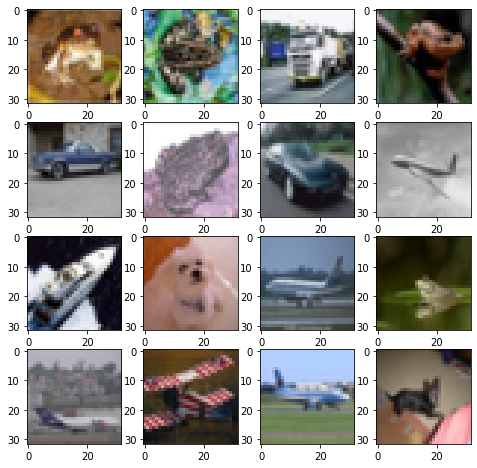

In [30]:
fig = plt.figure(figsize=(8, 8))


columns = 4
rows = 4
ids = [0, 200, 1000, 5000, 
       10000, 10200, 11000, 15000,
       20000, 20200, 21000, 25000,
       30000, 30200, 31000, 35000]
for i in range(1, columns*rows +1):
    img = data['X_train'][ids[i-1],:,:,:].squeeze()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()


## Dataloaders

In [31]:
class CIFAR10_data(Dataset):
    def __init__(self,images,labels,transform=None):
        self.images=images
        self.labels=labels
        self.transform=transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        label = torch.tensor(self.labels[index],dtype=torch.long)
        image = self.images[index].astype('uint8')
        if self.transform:
            image = self.transform(image)
        return image,label
        

In [32]:
data_transform=transforms.ToTensor()

train_dataset = CIFAR10_data(data['X_train_new'],data['y_train_new'],data_transform)
val_dataset = CIFAR10_data(data['X_val'],data['y_val'],data_transform)
test_dataset = CIFAR10_data(data['X_test'],data['y_test'],data_transform)

train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

datatloaders={'train':train_dataloader,'val':val_dataloader,'test':test_dataloader}

In [33]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Fully-Connected model

In [34]:
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flt = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, NUM_CLASSES)
        self.relu=nn.ReLU(inplace=True)
        self.drop =  nn.Dropout(p=0.3)
    def forward(self,x):
        x=self.flt(x)
        x=self.drop(self.relu(self.fc1(x)))
        x=self.drop(self.relu(self.fc2(x)))
        x=self.drop(self.relu(self.fc3(x)))
        x=self.fc4(x)
        return x

## Training

In [35]:
fc_model=FullyConnectedNet()
print(fc_model)
print()
print('Number of parameters for FC model: '+str(count_parameters(fc_model)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fc_model.parameters())
best_fc_val_acc=0.0
best_fc_model=copy.deepcopy(fc_model)
dest_path_best_model='FC_best_model.pth'

history={'train_acc':[],'train_loss':[],'val_acc':[],'val_loss':[]}
num_batches=len(train_dataloader)
for epoch in range(NUM_EPOCHS):  
    print()
    print('Epoch '+str(epoch))
    print('-'*100)
    for phase in ['train','val']:
        if phase=='train':
            fc_model.train()
        else:
            fc_model.eval()
        running_loss = 0.0
        running_acc = 0.0
        samples=0
        for i, data_btch in enumerate(datatloaders[phase]):
            inputs, labels = data_btch
            optimizer.zero_grad()
            outputs = fc_model(inputs)
            loss = criterion(outputs, labels)
            
            if phase=='train':
                loss.backward()
                optimizer.step()

            samples += labels.size(0)
            running_loss += loss.item()*labels.size(0)
            _, predicted = torch.max(outputs, 1)
            running_acc += (predicted == labels).sum().item()
            if phase=='train':
                if i%100==0:
                    print('Batch {}/{}: loss: {}, acc: {}'.format(str(i),str(num_batches),str(running_loss/samples)[:6],str(running_acc/samples)[:6]))
        epoch_loss = float(running_loss)/samples
        epoch_acc = float(running_acc)/samples
        history[phase+'_acc'].append(epoch_acc)
        history[phase+'_loss'].append(epoch_loss)
        print('Epoch {}:  {} loss: {}, {} acc: {}'.format(str(epoch),phase,str(epoch_loss)[:6],phase,str(epoch_acc)[:6]))
        if phase=='val':
            if epoch_acc>best_fc_val_acc:
                print('Saving model, val acc improved from {} to {}'.format(str(best_fc_val_acc)[:6],str(epoch_acc)[:6]))
                best_fc_val_acc = epoch_acc
                best_fc_model = copy.deepcopy(fc_model)
                torch.save(fc_model.state_dict(),dest_path_best_model)
            else:
                print('val acc did not improve from {}'.format(str(best_fc_val_acc)[:6]))

FullyConnectedNet(
  (flt): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
  (drop): Dropout(p=0.3, inplace=False)
)

Number of parameters for FC model: 1738890

Epoch 0
----------------------------------------------------------------------------------------------------
Batch 0/2813: loss: 2.2917, acc: 0.125
Batch 100/2813: loss: 2.3052, acc: 0.1175
Batch 200/2813: loss: 2.2532, acc: 0.1299
Batch 300/2813: loss: 2.2117, acc: 0.1482
Batch 400/2813: loss: 2.1849, acc: 0.1567
Batch 500/2813: loss: 2.1661, acc: 0.1645
Batch 600/2813: loss: 2.1546, acc: 0.1710
Batch 700/2813: loss: 2.1415, acc: 0.1781
Batch 800/2813: loss: 2.1341, acc: 0.1820
Batch 900/2813: loss: 2.1316, acc: 0.1853
Batch 1000/2813: loss: 2.1249, acc: 0.1879
Batch 

Batch 600/2813: loss: 1.8894, acc: 0.3026
Batch 700/2813: loss: 1.8890, acc: 0.3032
Batch 800/2813: loss: 1.8862, acc: 0.3036
Batch 900/2813: loss: 1.8874, acc: 0.3040
Batch 1000/2813: loss: 1.8874, acc: 0.3041
Batch 1100/2813: loss: 1.8865, acc: 0.3069
Batch 1200/2813: loss: 1.8836, acc: 0.3091
Batch 1300/2813: loss: 1.8810, acc: 0.3090
Batch 1400/2813: loss: 1.8805, acc: 0.3091
Batch 1500/2813: loss: 1.8806, acc: 0.3081
Batch 1600/2813: loss: 1.8809, acc: 0.3078
Batch 1700/2813: loss: 1.8827, acc: 0.3070
Batch 1800/2813: loss: 1.8824, acc: 0.3078
Batch 1900/2813: loss: 1.8827, acc: 0.3081
Batch 2000/2813: loss: 1.8813, acc: 0.3078
Batch 2100/2813: loss: 1.8802, acc: 0.3084
Batch 2200/2813: loss: 1.8791, acc: 0.3092
Batch 2300/2813: loss: 1.8791, acc: 0.3096
Batch 2400/2813: loss: 1.8780, acc: 0.3095
Batch 2500/2813: loss: 1.8773, acc: 0.3100
Batch 2600/2813: loss: 1.8770, acc: 0.3102
Batch 2700/2813: loss: 1.8769, acc: 0.3106
Batch 2800/2813: loss: 1.8769, acc: 0.3104
Epoch 5:  train

Batch 2500/2813: loss: 1.8525, acc: 0.3229
Batch 2600/2813: loss: 1.8509, acc: 0.3236
Batch 2700/2813: loss: 1.8505, acc: 0.3239
Batch 2800/2813: loss: 1.8515, acc: 0.3236
Epoch 10:  train loss: 1.8512, train acc: 0.3236
Epoch 10:  val loss: 1.7561, val acc: 0.3844
Saving model, val acc improved from 0.3606 to 0.3844

Epoch 11
----------------------------------------------------------------------------------------------------
Batch 0/2813: loss: 1.8314, acc: 0.1875
Batch 100/2813: loss: 1.8218, acc: 0.3285
Batch 200/2813: loss: 1.8503, acc: 0.3317
Batch 300/2813: loss: 1.8430, acc: 0.3324
Batch 400/2813: loss: 1.8411, acc: 0.3329
Batch 500/2813: loss: 1.8505, acc: 0.3257
Batch 600/2813: loss: 1.8480, acc: 0.3287
Batch 700/2813: loss: 1.8496, acc: 0.3295
Batch 800/2813: loss: 1.8468, acc: 0.3284
Batch 900/2813: loss: 1.8465, acc: 0.3285
Batch 1000/2813: loss: 1.8468, acc: 0.3282
Batch 1100/2813: loss: 1.8464, acc: 0.3267
Batch 1200/2813: loss: 1.8439, acc: 0.3272
Batch 1300/2813: loss: 

Batch 1000/2813: loss: 1.8269, acc: 0.3341
Batch 1100/2813: loss: 1.8261, acc: 0.3341
Batch 1200/2813: loss: 1.8285, acc: 0.3333
Batch 1300/2813: loss: 1.8286, acc: 0.3324
Batch 1400/2813: loss: 1.8288, acc: 0.3322
Batch 1500/2813: loss: 1.8260, acc: 0.3327
Batch 1600/2813: loss: 1.8276, acc: 0.3320
Batch 1700/2813: loss: 1.8276, acc: 0.3326
Batch 1800/2813: loss: 1.8270, acc: 0.3334
Batch 1900/2813: loss: 1.8280, acc: 0.3323
Batch 2000/2813: loss: 1.8297, acc: 0.3323
Batch 2100/2813: loss: 1.8297, acc: 0.3321
Batch 2200/2813: loss: 1.8301, acc: 0.3320
Batch 2300/2813: loss: 1.8319, acc: 0.3316
Batch 2400/2813: loss: 1.8319, acc: 0.3316
Batch 2500/2813: loss: 1.8314, acc: 0.3318
Batch 2600/2813: loss: 1.8306, acc: 0.3322
Batch 2700/2813: loss: 1.8316, acc: 0.3314
Batch 2800/2813: loss: 1.8316, acc: 0.3313
Epoch 16:  train loss: 1.8316, train acc: 0.3312
Epoch 16:  val loss: 1.7746, val acc: 0.3656
val acc did not improve from 0.3844

Epoch 17
-------------------------------------------

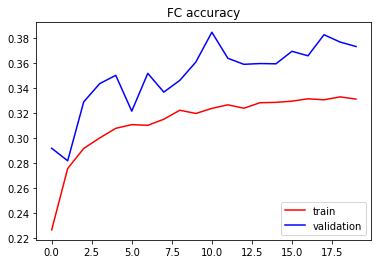

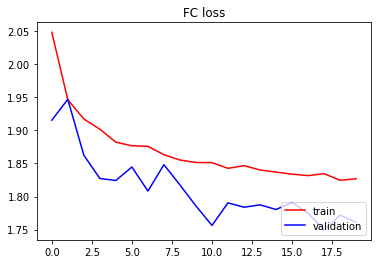

In [36]:
plt.plot(history['train_acc'],c='red')
plt.plot(history['val_acc'],c='blue')
plt.legend(["train", "validation"], loc ="lower right")
plt.title('FC accuracy')
plt.show()
plt.clf()

plt.plot(history['train_loss'],c='red')
plt.plot(history['val_loss'],c='blue')
plt.legend(["train", "validation"], loc ="lower right")
plt.title('FC loss')
plt.show()


## CNN model

In [37]:
class CNNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3,padding='same')
        
        self.conv3 = nn.Conv2d(64, 128, 3,padding='same')
        self.conv4 = nn.Conv2d(128, 128, 3,padding='same')
        
        self.conv5 = nn.Conv2d(128, 256, 3,padding='same')
        self.conv6 = nn.Conv2d(256, 256, 3,padding='same')
        
        self.fc1 = nn.Linear(4096, 128)
        self.fc2= nn.Linear(128, NUM_CLASSES)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.flt = nn.Flatten()
        self.relu= nn.ReLU(inplace=True)
        self.drop1 =  nn.Dropout(p=0.2)
        self.drop2 =  nn.Dropout(p=0.3)

    def forward(self, x):
        x=self.relu(self.conv1(x))
        x=self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop1(x)
        
        x=self.relu(self.conv3(x))
        x=self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.drop1(x)
        
        x=self.relu(self.conv5(x))
        x=self.relu(self.conv6(x))
        x = self.pool(x)
        x = self.drop1(x)

        x = self.flt(x)
        x = self.drop2(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [38]:
cnn_model = CNNNet()
print()
print('Number of parameters for CNN model: '+str(count_parameters(cnn_model)))

cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters())

best_cnn_val_acc=0.0
best_cnn_model=copy.deepcopy(cnn_model)
dest_path_best_model='CNN_best_model.pth'

history_cnn={'train_acc':[],'train_loss':[],'val_acc':[],'val_loss':[]}

num_batches=len(train_dataloader)
for epoch in range(NUM_EPOCHS):  
    print()
    print('Epoch '+str(epoch))
    print('-'*100)
    for phase in ['train','val']:
        if phase=='train':
            cnn_model.train()
        else:
            cnn_model.eval()
        running_loss = 0.0
        running_acc = 0.0
        samples=0
        for i, data_btch in enumerate(datatloaders[phase]):
            inputs, labels = data_btch
            cnn_optimizer.zero_grad()
            outputs = cnn_model(inputs)
            cnn_loss = cnn_criterion(outputs, labels)
            
            if phase=='train':
                cnn_loss.backward()
                cnn_optimizer.step()

            samples += labels.size(0)
            running_loss += cnn_loss.item()*labels.size(0)
            _, predicted = torch.max(outputs, 1)
            running_acc += (predicted == labels).sum().item()
            if phase=='train':
                if i%100==0:
                    print('Batch {}/{}: loss: {}, acc: {}'.format(str(i),str(num_batches),str(running_loss/samples)[:6],str(running_acc/samples)[:6]))
        epoch_loss = float(running_loss)/samples
        epoch_acc = float(running_acc)/samples
        history_cnn[phase+'_acc'].append(epoch_acc)
        history_cnn[phase+'_loss'].append(epoch_loss)
        print('Epoch {}:  {} loss: {}, {} acc: {}'.format(str(epoch),phase,str(epoch_loss)[:6],phase,str(epoch_acc)[:6]))
        if phase=='val':
            if epoch_acc>best_cnn_val_acc:
                print('Saving model, val acc improved from {} to {}'.format(str(best_cnn_val_acc)[:6],str(epoch_acc)[:6]))
                best_cnn_val_acc = epoch_acc
                best_cnn_model = copy.deepcopy(cnn_model)
                torch.save(cnn_model.state_dict(),dest_path_best_model)
            else:
                print('val acc did not improve from {}'.format(str(best_cnn_val_acc)[:6]))


Number of parameters for CNN model: 1671114

Epoch 0
----------------------------------------------------------------------------------------------------
Batch 0/2813: loss: 2.2942, acc: 0.125
Batch 100/2813: loss: 2.3044, acc: 0.1002
Batch 200/2813: loss: 2.3004, acc: 0.1072
Batch 300/2813: loss: 2.2644, acc: 0.1293
Batch 400/2813: loss: 2.2241, acc: 0.1500
Batch 500/2813: loss: 2.1874, acc: 0.1672
Batch 600/2813: loss: 2.1594, acc: 0.1804
Batch 700/2813: loss: 2.1310, acc: 0.1924
Batch 800/2813: loss: 2.1026, acc: 0.2040
Batch 900/2813: loss: 2.0764, acc: 0.2158
Batch 1000/2813: loss: 2.0505, acc: 0.2258
Batch 1100/2813: loss: 2.0289, acc: 0.2345
Batch 1200/2813: loss: 2.0089, acc: 0.2417
Batch 1300/2813: loss: 1.9909, acc: 0.2484
Batch 1400/2813: loss: 1.9692, acc: 0.2575
Batch 1500/2813: loss: 1.9524, acc: 0.2635
Batch 1600/2813: loss: 1.9377, acc: 0.2695
Batch 1700/2813: loss: 1.9236, acc: 0.2760
Batch 1800/2813: loss: 1.9094, acc: 0.2812
Batch 1900/2813: loss: 1.8950, acc: 0.286

Batch 1500/2813: loss: 0.9737, acc: 0.6588
Batch 1600/2813: loss: 0.9709, acc: 0.6597
Batch 1700/2813: loss: 0.9702, acc: 0.6596
Batch 1800/2813: loss: 0.9725, acc: 0.6590
Batch 1900/2813: loss: 0.9720, acc: 0.6590
Batch 2000/2813: loss: 0.9697, acc: 0.6598
Batch 2100/2813: loss: 0.9686, acc: 0.6606
Batch 2200/2813: loss: 0.9695, acc: 0.6604
Batch 2300/2813: loss: 0.9680, acc: 0.6604
Batch 2400/2813: loss: 0.9674, acc: 0.6613
Batch 2500/2813: loss: 0.9680, acc: 0.6617
Batch 2600/2813: loss: 0.9681, acc: 0.6618
Batch 2700/2813: loss: 0.9685, acc: 0.6617
Batch 2800/2813: loss: 0.9682, acc: 0.6623
Epoch 5:  train loss: 0.9680, train acc: 0.6623
Epoch 5:  val loss: 0.9133, val acc: 0.6916
val acc did not improve from 0.7132

Epoch 6
----------------------------------------------------------------------------------------------------
Batch 0/2813: loss: 1.0060, acc: 0.625
Batch 100/2813: loss: 0.9578, acc: 0.6683
Batch 200/2813: loss: 0.9476, acc: 0.6713
Batch 300/2813: loss: 0.9488, acc: 0.

Batch 0/2813: loss: 0.6418, acc: 0.75
Batch 100/2813: loss: 0.7334, acc: 0.7444
Batch 200/2813: loss: 0.7394, acc: 0.7450
Batch 300/2813: loss: 0.7445, acc: 0.7425
Batch 400/2813: loss: 0.7529, acc: 0.7408
Batch 500/2813: loss: 0.7590, acc: 0.7400
Batch 600/2813: loss: 0.7577, acc: 0.7413
Batch 700/2813: loss: 0.7630, acc: 0.7407
Batch 800/2813: loss: 0.7708, acc: 0.7371
Batch 900/2813: loss: 0.7699, acc: 0.7365
Batch 1000/2813: loss: 0.7716, acc: 0.7357
Batch 1100/2813: loss: 0.7743, acc: 0.7338
Batch 1200/2813: loss: 0.7764, acc: 0.7328
Batch 1300/2813: loss: 0.7744, acc: 0.7328
Batch 1400/2813: loss: 0.7724, acc: 0.7337
Batch 1500/2813: loss: 0.7718, acc: 0.7337
Batch 1600/2813: loss: 0.7722, acc: 0.7339
Batch 1700/2813: loss: 0.7729, acc: 0.7336
Batch 1800/2813: loss: 0.7745, acc: 0.7328
Batch 1900/2813: loss: 0.7735, acc: 0.7331
Batch 2000/2813: loss: 0.7749, acc: 0.7322
Batch 2100/2813: loss: 0.7766, acc: 0.7314
Batch 2200/2813: loss: 0.7787, acc: 0.7308
Batch 2300/2813: loss: 0.

Batch 1900/2813: loss: 0.7053, acc: 0.7564
Batch 2000/2813: loss: 0.7045, acc: 0.7571
Batch 2100/2813: loss: 0.7052, acc: 0.7569
Batch 2200/2813: loss: 0.7051, acc: 0.7574
Batch 2300/2813: loss: 0.7070, acc: 0.7571
Batch 2400/2813: loss: 0.7052, acc: 0.7580
Batch 2500/2813: loss: 0.7064, acc: 0.7576
Batch 2600/2813: loss: 0.7077, acc: 0.7577
Batch 2700/2813: loss: 0.7077, acc: 0.7579
Batch 2800/2813: loss: 0.7072, acc: 0.7582
Epoch 16:  train loss: 0.7073, train acc: 0.7582
Epoch 16:  val loss: 0.7098, val acc: 0.7656
Saving model, val acc improved from 0.7644 to 0.7656

Epoch 17
----------------------------------------------------------------------------------------------------
Batch 0/2813: loss: 0.7116, acc: 0.8125
Batch 100/2813: loss: 0.6623, acc: 0.7827
Batch 200/2813: loss: 0.6691, acc: 0.7764
Batch 300/2813: loss: 0.6609, acc: 0.7745
Batch 400/2813: loss: 0.6623, acc: 0.7741
Batch 500/2813: loss: 0.6732, acc: 0.7660
Batch 600/2813: loss: 0.6750, acc: 0.7662
Batch 700/2813: loss

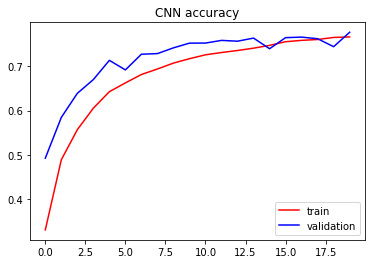

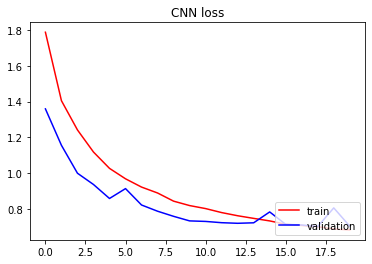

In [39]:
plt.plot(history_cnn['train_acc'],c='red')
plt.plot(history_cnn['val_acc'],c='blue')
plt.legend(["train", "validation"], loc ="lower right")
plt.title('CNN accuracy')
plt.show()
plt.clf()

plt.plot(history_cnn['train_loss'],c='red')
plt.plot(history_cnn['val_loss'],c='blue')
plt.legend(["train", "validation"], loc ="lower right")
plt.title('CNN loss')
plt.show()


## Testing and comparing both models

In [40]:
##FC model
fc_model = FullyConnectedNet()
fc_model.load_state_dict(torch.load('FC_best_model.pth'))
fc_model.eval()
with torch.no_grad():
    for i, data_btch in enumerate(datatloaders['test']):
            inputs, labels = data_btch
            outputs = fc_model(inputs)
            _, predicted = torch.max(outputs, 1)
            samples += labels.size(0)
            running_acc += (predicted == labels).sum().item()
    acc = running_acc/samples
    print('FC model test accuracy: ',acc)
            
        
        
cnn_model = CNNNet()
cnn_model.load_state_dict(torch.load('CNN_best_model.pth'))
cnn_model.eval()
with torch.no_grad():
    for i, data_btch in enumerate(datatloaders['test']):
            inputs, labels = data_btch
            outputs = cnn_model(inputs)
            _, predicted = torch.max(outputs, 1)
            samples += labels.size(0)
            running_acc += (predicted == labels).sum().item()
    acc = running_acc/samples
    print('CNN model test accuracy: ',acc)

FC model test accuracy:  0.5146
CNN model test accuracy:  0.61224
